# Text to Speech

When solving some problem with deep learning in practice, you search the Web for the latest paper that solves that task, and take its implementation from GitHub. However, often there is no code, so being able to **reimplement a paper** is a vital skill. You will likely have to do it in your course project, and we are going to practice it in this assignment.

Let's focus on the task of text-to-speech (**TTS**) synthesis.

![](https://user-images.githubusercontent.com/9570420/81783573-392ed600-9504-11ea-98da-86ac05457c29.png)

## Data

 Intuitively, in the real world your dataset would be a set of pairs:

* text (string);
* **target**: raw audio of a person saying `text` (array of amplitude values sampled e.g. 44100 times per second — see an example plotted above).

We give you a simplified problem statement, with one dataset sample being an utterance described by

* list of [ARPAbet phonemes](http://www.speech.cs.cmu.edu/cgi-bin/cmudict#phones);
* *phoneme alignment*, i.e. start time (frame) and duration for each phoneme;
* **target**: [mel spectrogram](https://pytorch.org/audio/transforms.html#torchaudio.transforms.MelSpectrogram) of a person saying text.

![image](https://user-images.githubusercontent.com/9570420/81795777-2a9cea80-9515-11ea-99eb-05915f803af1.png)

In [0]:
import scipy.io.wavfile

import torch
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import random
from pathlib import Path

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [0]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/Belov_Aleksandr_DL_HW4")
    print(AUX_DATA_ROOT)
    assert AUX_DATA_ROOT.is_dir(), "Have you forgotten to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.insert(0, str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

In [0]:
![ ! -d "LJ-Speech-aligned" ] && unzip -q "{AUX_DATA_ROOT / 'LJ-Speech-aligned.zip'}"
!git clone --recursive https://github.com/shrubb/waveglow.git -b denoiser-fix
!wget -c https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ljs_256channels/versions/2/files/waveglow_256channels_ljs_v2.pt

Use this Python module to handle our dataset. It's documented, so when in doubt, use `help()` or read the code with `??lj_speech`.

In [6]:
!pip install git+https://github.com/shrubb/listener.git
import lj_speech

  Cloning https://github.com/shrubb/listener.git to /tmp/pip-req-build-8hpad63d
  Running command git clone -q https://github.com/shrubb/listener.git /tmp/pip-req-build-8hpad63d
  Created wheel for listener: filename=listener-1.0.0a1-cp36-none-any.whl size=87098 sha256=903b368061adf2f125a221e5c2af1d18db4eab209904579761964fe46235fc1f
  Stored in directory: /tmp/pip-ephem-wheel-cache-pf0g7uy3/wheels/41/ec/98/7c89227ba5da35ff1e7d5284bb58e0b98e93389fc1f77c407b
Successfully built listener


In [0]:
DATASET_ROOT = Path('LJ-Speech-aligned/')

train_dataset, val_dataset = lj_speech.get_dataset(DATASET_ROOT)

There are also a couple of useful constants, check them with `?lj_speech`.

In [8]:
len(lj_speech.POSSIBLE_PHONEME_CODES)

54

Here is an example datapoint:

Datasets yield: text, phonemes_start, phonemes_duration, phonemes_code, spectrogram


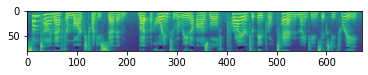

In [10]:
example_datapoint = train_dataset[666]
print(f"Datasets yield: {', '.join(example_datapoint.keys())}")
plt.imshow(example_datapoint['spectrogram']);

To "play" spectrograms, including those that you will generate, we will use another deep learning algorithm called [WaveGlow](https://arxiv.org/abs/1811.00002). It converts mel spectrograms to audio.

Fortunately, there *is* code for it on GitHub, so you won't have to reimplement it 🙂 Still, if you haven't done so, I encourage you to watch a short [video](https://www.youtube.com/watch?v=CqFIVCD1WWo) about a famous paper that it's based on.

In [0]:
vocoder = lj_speech.Vocoder()

In [12]:
print(example_datapoint['text'])

example_spectrogram = torch.from_numpy(example_datapoint['spectrogram'])
audio = vocoder(example_spectrogram)
lj_speech.play_audio(audio)

sometime after march twenty-seven, but according to marina oswald, prior to april ten, nineteen sixty-three,


Finally, we have phonemes as inputs, but we'd like to synthesize arbitrary text. For that, there is a function `lj_speech.text_to_phonemes(text)`.

In [13]:
lj_speech.text_to_phonemes('I like coding')

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


['AY1', 'L', 'AY1', 'K', 'K', 'OW1', 'D', 'IH0', 'NG']

## Method

Reimplement the baseline method defined by the diagram below. It's derived from a simplified version of the [DurIAN paper](https://arxiv.org/abs/1909.01700).

Just in case, here are some of the most notable differences from DurIAN:
* Prosodic boundary markers aren't used (we don't have them labeled), and thus there's no 'skip states' exclusion of prosodic boundaries' hidden states.
* Style codes aren't used too (same).
* Simpler network architectures.
* No pre-net in decoder.
* No attention used in decoder.
* Decoder's recurrent cell outputs single spectrogram frame at a time.
* Decoder's recurrent cell isn't conditioned on its own outputs (isn't "autogressive").

![pipeline](https://user-images.githubusercontent.com/9570420/81863803-6f0ba300-9574-11ea-9f02-481c2bba81f0.png)

This picture is the simplified Figure 1 from the paper. **Use the paper as a reference**. If something is unclear from the diagram — and, in fact, some things are intentionally omitted — search answers in the paper (but remain aware of the differences/simplifications in the above diagram) and other papers that the authors cite. There will even be details that aren't even mentioned anywhere in the paper, so you'll have to guess by your intuition. For instance, DurIAN paper doesn't explain batch size and sampling strategy, and even if it did, it would be irrelevant since we use different data. Finally, search the Web and read others' code; however, if you copy-paste code, **cite it**.

Tips:
* Only compute loss on the 'original' parts of the spectrograms (don't include padding)!
* When using recurrent nets, [clip gradients' norm](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.clip_grad_norm_).
* Since you will use recurrent nets, and the sequences in a batch will be of different lengths, you may find [sequence packing utility](https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch) useful.
* Remember that you can send images and audio into TensorBoard, too.

**Train this baseline so that the words are well-recognizable, and try to get rid of the "metallic", "tin sounding" voice.**

**Aim for something like this:**

In [14]:
lj_speech.play_audio(scipy.io.wavfile.read(AUX_DATA_ROOT / 'ok.wav')[1])

**On the other hand, here is an example of insufficient quality:**

In [15]:
lj_speech.play_audio(scipy.io.wavfile.read(AUX_DATA_ROOT / 'bad.wav')[1])

## Improving the Method

When you have the baseline working, seek the ways to improve quality and to decrease loss. Look into the paper and the relevant/neighbouring literature. Also, follow your intuition, e.g. for changing model complexity or regularization. For example, you can (but aren't obliged to) try borrowing more tricks from DurIAN; a couple of examples for inspiration:

* Make decoder recurrent cell autoregressive as in the paper: use its output as its input at the next preiction step.
* Add pre-net to decoder.
* Add attention to decoder.
* Use more complex sub-network architectures (e.g. use CBHG).
* Employ tricks from Tacotron {[1](https://arxiv.org/abs/1703.10135),[2](https://arxiv.org/abs/1712.05884)} — papers that DurIAN is based upon, e.g. [zoneout](https://arxiv.org/abs/1606.01305) in RNNs.

Write a report on your journey to better loss. Explain if you managed to perceptibly improve the quality and lower the loss, what you tried and why, what worked and what didn't. Include TensorBoard loss plots.

## Deliverables

1. This file, fully functional, reproducing all the reported results on "Run all". Out-of-the box `TextToSpeechSynthesizer` class (see interface below) and demo code of running it on arbitrary text.
2. Report on improving the baseline at the end of this file.
3. Two "checkpoint files" with weights for both of your models (baseline and the improved model).

## Grading

* **[7 points]** Baseline.
* **[3 points]** Improving of the baseline.

In [0]:
class TextToSpeechSynthesizer:
    """
    When done, please fill this class. It should work out-of-the-box, i.e.
    have a simple interface, automatically load model weights,
    process text to speech at one command without errors etc.
    """
    def __init__(self, checkpoint_path, <any-other-arguments>):
        """
        Initialize anything you may need. For example, load model weights from disk.
        """
        pass
    
    def synthesize_from_text(self, text):
        """
        Synthesize text into voice.

        text:
            str
        
        return:
        audio:
            torch.Tensor or numpy.ndarray, shape == (1, t)
        """
        phonemes = lj_speech.text_to_phonemes(text)
        return self.synthesize_from_phonemes(phonemes)

    def synthesize_from_phonemes(self, phonemes, durations=None):
        """
        Synthesize phonemes into voice.

        phonemes:
            list of str
            ARPAbet phoneme codes.
        durations:
            list of int, optional
            Duration in spectrogram frames for each phoneme.
            If given, will be used for hard alignment in the model (like during
            training); otherwise, durations will be predicted by the duration
            model.
        
        return:
        audio:
            torch.Tensor or numpy.ndarray, shape == (1, t)
        """
        # Your code here

        spectrogram = ...
        return vocoder(spectrogram)

In [0]:
# Example:
synthesizer = TextToSpeechSynthesizer("./baseline.pth", <any-other-arguments>)

In [0]:
phonemes = "DH IH1 S pau pau pau IH1 Z pau pau pau S P AH1 R T AH1 AH1 AH1 pau".split()
lj_speech.play_audio(
    synthesizer.synthesize_from_phonemes(phonemes))

In [0]:
text = "Pack my box with five dozen liquor jugs."
# text = "The five boxing wizards jump quickly."
# text = "The quick brown fox jumps over the lazy dog."
# text = "How about some school tech."
# text = "Last homework. We are in a deep trouble. No sleep tonight."

lj_speech.play_audio(
    synthesizer.synthesize_from_text(text))